In [20]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Helper functions
def get_contour(mask: np.ndarray):
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    erosion = cv2.erode(thresh, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

def crop_image(img, contour):
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    img = cv2.bitwise_and(img, mask)
    return img


In [21]:
# Convert the image from format tif to png
image_path = 'D:\\data\\data\\train\\P1MF1_N.png'
im = Image.open(image_path)
im.save(image_path[:-3] + 'png')
image_path = image_path[:-3] + 'png'


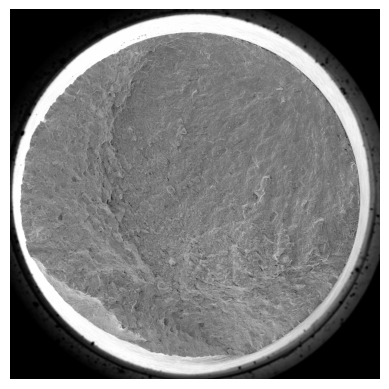

In [22]:
img = cv2.imread(image_path)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


Original Image Shape: (4096, 4096, 3)
Cropped Image Shape: (4096, 4096, 3)


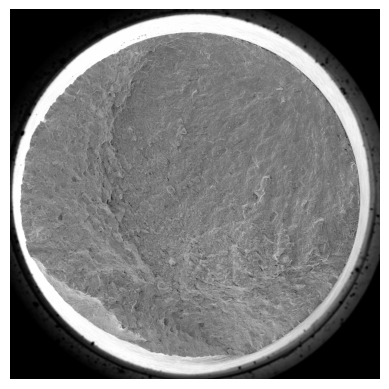

In [23]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, width = gray.shape
print("Original Image Shape:", img.shape)
img = img[0:width, 0:width]
cv2.imwrite(image_path, img)
print("Cropped Image Shape:", img.shape)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [24]:
# Load the models
ext_model_path = 'D:\\unet_model\\unet_model'
int_model_path = 'D:\\internal_smaller_mask_unet_model\\internal_smaller_mask_unet_model'
ex_cnt_model = tf.keras.models.load_model(ext_model_path)
in_cnt_model = tf.keras.models.load_model(int_model_path)


1/1 [==============================] - 1s 1s/step


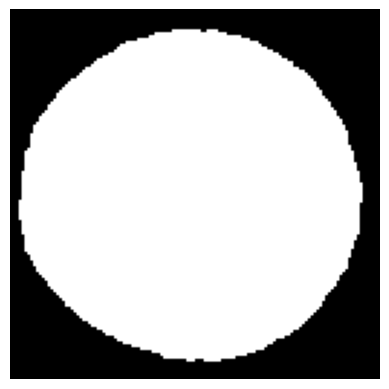

In [25]:
# Load the original image
original_img = cv2.imread(image_path)

# Predict the external mask
ext_mask = predict_mask(original_img, ex_cnt_model)

# Display the external mask
plt.axis('off')
plt.imshow(ext_mask, cmap='gray')
plt.show()


In [27]:
# Get the contour from the mask
ext_contour = get_contour(ext_mask)
ext_contour = ext_contour * (original_img.shape[0] / 128)
ext_contour = ext_contour.astype(np.int32)


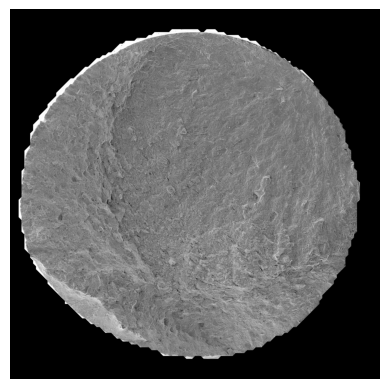

In [28]:
# Crop the image using the external mask
cropped_img = crop_image(original_img, ext_contour)
plt.axis('off')
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.show()


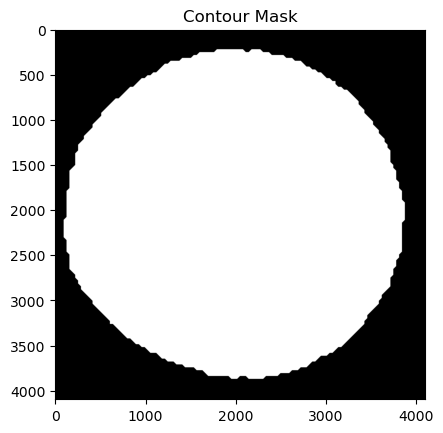

In [29]:
# Create a contour mask
img_grey = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
mask = np.zeros(img_grey.shape, np.uint8)
cv2.drawContours(mask, [ext_contour], -1, (255, 255, 255), -1, cv2.LINE_AA)

# Display contour mask
plt.figure()
plt.title("Contour Mask")
plt.imshow(mask, cmap='gray')
plt.show()


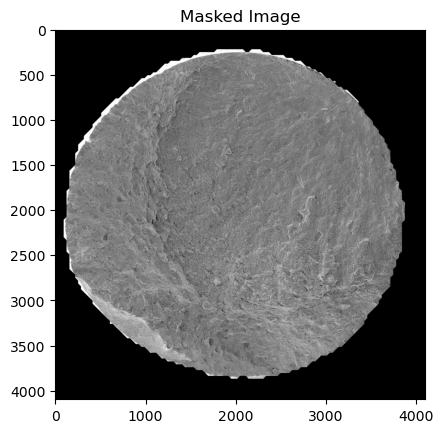

In [30]:
# Apply mask to the image
out = np.zeros_like(original_img)
out[mask == 255] = original_img[mask == 255]
img_color = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

# Display masked image
plt.figure()
plt.title("Masked Image")
plt.imshow(img_color)
plt.show()


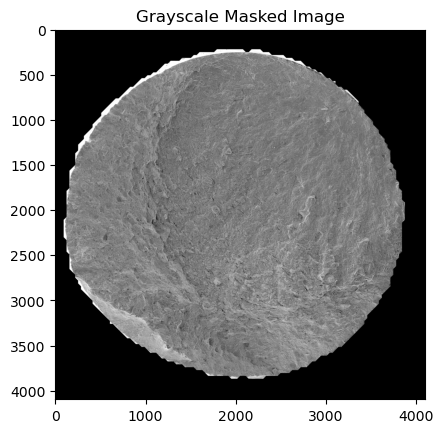

In [31]:
# Convert masked image to grayscale
img_grey = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Display grayscale masked image
plt.figure()
plt.title("Grayscale Masked Image")
plt.imshow(img_grey, cmap='gray')
plt.show()


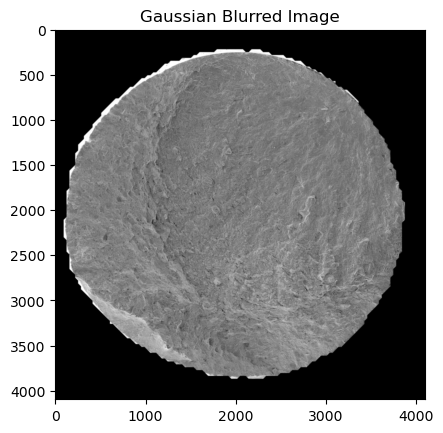

In [32]:
# Apply Gaussian blur
blur = cv2.GaussianBlur(img_grey, (13, 13), 0)

# Display blurred image
plt.figure()
plt.title("Gaussian Blurred Image")
plt.imshow(blur, cmap='gray')
plt.show()


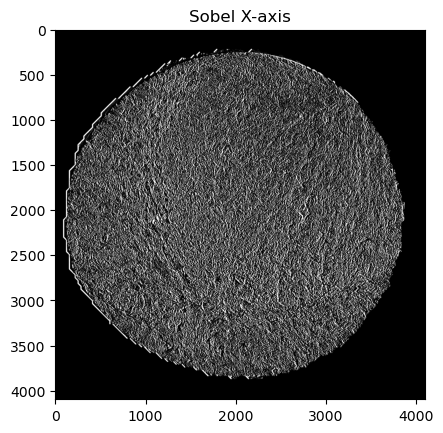

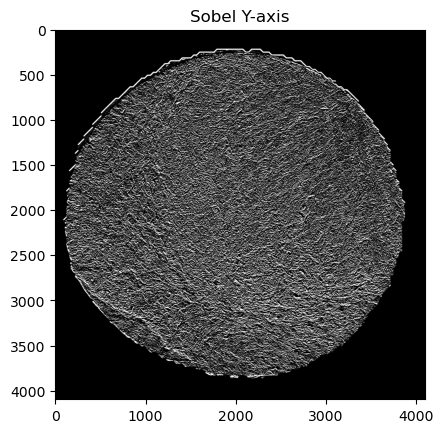

In [33]:
# Apply Sobel filter on x-axis
sobelx = cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=5)

# Display Sobel x-axis
plt.figure()
plt.title("Sobel X-axis")
plt.imshow(sobelx, cmap='gray')
plt.show()

# Apply Sobel filter on y-axis
sobely = cv2.Sobel(blur, cv2.CV_8U, 0, 1, ksize=5)

# Display Sobel y-axis
plt.figure()
plt.title("Sobel Y-axis")
plt.imshow(sobely, cmap='gray')
plt.show()


Pixel value range after Sobel operator: 0 255


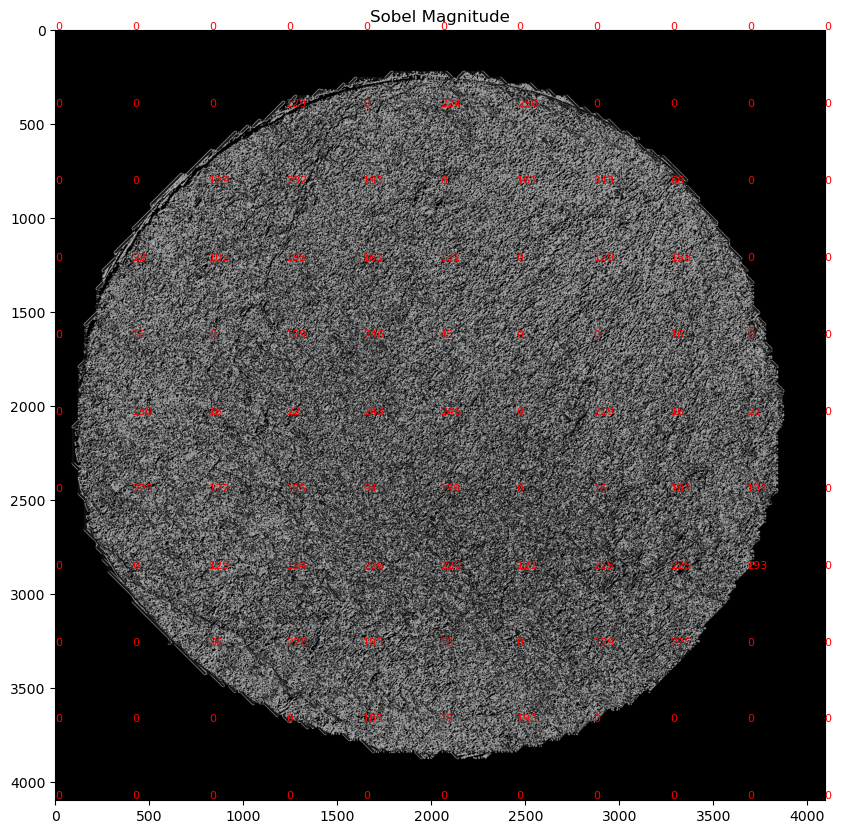

In [34]:
# Compute magnitude of the gradient
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
sobel_magnitude = sobel_magnitude / sobel_magnitude.max() * 255
sobel_magnitude = np.uint8(sobel_magnitude)

# Check the range of pixel values in the Sobel magnitude image
print("Pixel value range after Sobel operator:", sobel_magnitude.min(), sobel_magnitude.max())

# Display Sobel magnitude with pixel values
plt.figure(figsize=(10, 10))
plt.title("Sobel Magnitude")
plt.imshow(sobel_magnitude, cmap='gray')

# Annotate a small portion of the image with pixel values
for i in range(0, sobel_magnitude.shape[0], sobel_magnitude.shape[0] // 10):
    for j in range(0, sobel_magnitude.shape[1], sobel_magnitude.shape[1] // 10):
        plt.text(j, i, str(sobel_magnitude[i, j]), color='red', fontsize=8)
plt.show()


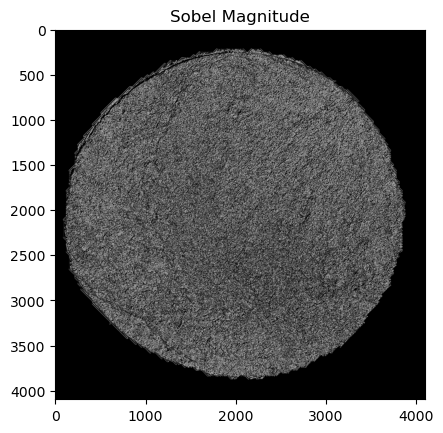

In [64]:
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
sobel_magnitude = sobel_magnitude / sobel_magnitude.max() * 255
sobel_magnitude = np.uint8(sobel_magnitude)

# Display Sobel magnitude
plt.figure()
plt.title("Sobel Magnitude")
plt.imshow(sobel_magnitude, cmap='gray')
plt.show()

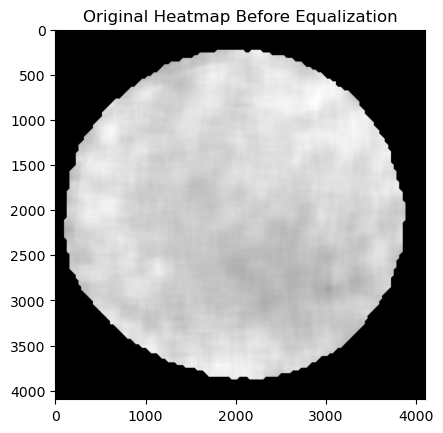

In [65]:
# Create heatmap
window_size = 201  # Odd number only
window_step = 10
heat_map_sobel = np.zeros(sobel_magnitude.shape, dtype=np.uint8)
sobel_c = np.pad(sobel_magnitude, int((window_size-1)/2), mode='constant', constant_values=0)
mask_metal_c = np.pad(mask, int((window_size-1)/2), mode='constant', constant_values=0)

for y in range(0, sobel_c.shape[0], window_step):
    for x in range(0, sobel_c.shape[1], window_step):
        window = sobel_c[y:y+window_size, x:x+window_size]
        mask_metal_window = mask_metal_c[y:y+window_size, x:x+window_size]/255
        if mask_metal_window.sum() == 0 or mask_metal_window[(int((window_size - 1) / 2)), (int((window_size - 1) / 2))] == 0:
            heat_map_sobel[y:y+window_size, x:x+window_size] = 0
        else:
            heat_map_sobel[y:y+window_step, x:x+window_step] = np.sum(window)/mask_metal_window.sum()

# Display original heatmap before equalization
plt.figure()
plt.title("Original Heatmap Before Equalization")
plt.imshow(heat_map_sobel, cmap='gray')
plt.show()


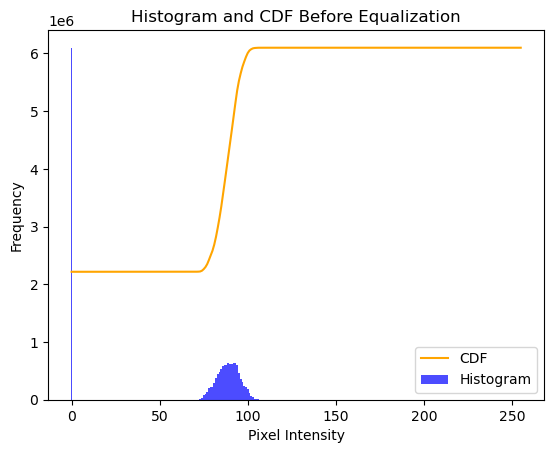

In [66]:
# Plot histogram before equalization with CDF
plt.figure()
plt.title("Histogram and CDF Before Equalization")

# Calculate histogram
hist_before, bins_before = np.histogram(heat_map_sobel.ravel(), bins=256, range=[0, 256])

# Plot histogram
plt.bar(bins_before[:-1], hist_before, width=1, color='blue', alpha=0.7, label='Histogram')

# Calculate and plot CDF
cdf_before = hist_before.cumsum()
cdf_normalized_before = cdf_before * hist_before.max() / cdf_before.max()
plt.plot(cdf_normalized_before, color='orange', label='CDF')

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


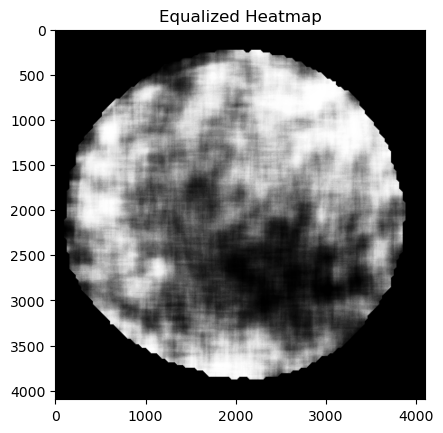

In [67]:
# Equalize the histogram
heat_map_sobel = cv2.equalizeHist(heat_map_sobel)

# Display equalized heatmap
plt.figure()
plt.title("Equalized Heatmap")
plt.imshow(heat_map_sobel, cmap='gray')
plt.show()


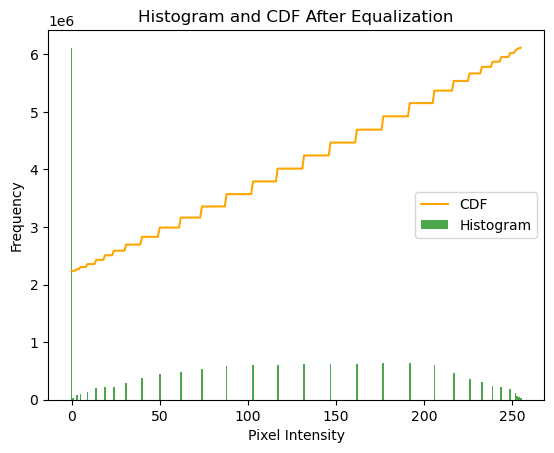

In [68]:
# Plot histogram after equalization with CDF
plt.figure()
plt.title("Histogram and CDF After Equalization")

# Calculate histogram
hist_after, bins_after = np.histogram(heat_map_sobel.ravel(), bins=256, range=[0, 256])

# Plot histogram
plt.bar(bins_after[:-1], hist_after, width=1, color='green', alpha=0.7, label='Histogram')

# Calculate and plot CDF
cdf_after = hist_after.cumsum()
cdf_normalized_after = cdf_after * hist_after.max() / cdf_after.max()
plt.plot(cdf_normalized_after, color='orange', label='CDF')

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


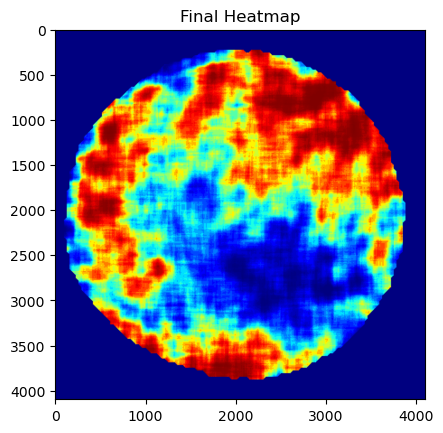

In [69]:
# Apply color map
heat_map_color_sobel = cv2.applyColorMap(heat_map_sobel, cv2.COLORMAP_JET)
heat_map_color_sobel_rgb = cv2.cvtColor(heat_map_color_sobel, cv2.COLOR_BGR2RGB)

# Display final heatmap
plt.figure()
plt.title("Final Heatmap")
plt.imshow(heat_map_color_sobel_rgb)
plt.show()